In [2]:
from spectrum_image import EELS
from spectrum_image.EELS.EELS_edge import EELS_edge
from spectrum_image.EELS import EELS_util
import os
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

%load_ext autoreload
%autoreload 2

In [3]:
## File and microscope parameters
path = "./"
SIdm = "STEM SI.dm4" # data file name

In [4]:
SI_file=hs.load(path+SIdm)
hs_survey = SI_file[0]
hs_ADF = SI_file[1]
hs_LL = SI_file[2]
hs_HL = SI_file[3]

WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all h

In [18]:
survey = hs_survey.data
adf = hs_ADF.data

In [19]:
es_LL, si_LL, pxscale, disp, params = EELS.EELS_util.get_hyperspy_data( hs_LL )
es_HL, si_HL, pxscale, disp, params = EELS.EELS_util.get_hyperspy_data( hs_HL )

<Axes manager, axes: (40, 58|2048)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     40 |      0 |      -0 |   0.001 |     µm 
               y |     58 |      0 |      -0 |   0.001 |     µm 
---------------- | ------ | ------ | ------- | ------- | ------ 
     Energy loss |   2048 |      0 |     -30 |    0.15 |     eV 
<Axes manager, axes: (40, 58|2048)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     40 |      0 |      -0 |   0.001 |     µm 
               y |     58 |      0 |      -0 |   0.001 |     µm 
---------------- | ------ | ------ | ------- | ------- | ------ 
     Energy loss |   2048 |      0 | 4.5e+02 |    0.15 |     eV 


## Correct Spectrum scan drift by fitting ZLP

In [20]:
# Construct Gaussian Model in lmfit
from lmfit.models import GaussianModel
zlp_model = GaussianModel()

results = EELS_util.fit_feature_si( si_LL, es_LL, model=zlp_model, e_bound=(-5,5))

Fitting Features:   0%|          | 0/2320 [00:00<?, ?it/s]

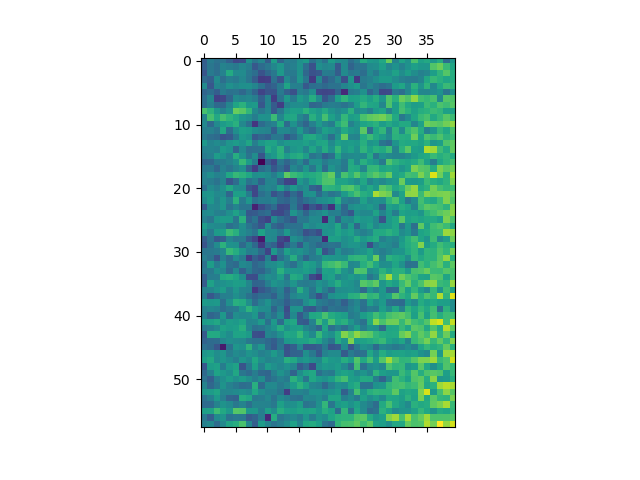

In [21]:
# Extract shift from fitted Gaussian
(ny,nx) = results.shape
centers = np.zeros( (ny,nx) )
for i in range(ny):
    for j in range(nx):
        centers[i,j] = results[i,j].params['center'].value

shifts = -centers
fig,ax = plt.subplots(1)
ax.matshow( shifts)

In [22]:
si_LL_shifted,es_LL_shifted = EELS_util.shift_SI( si_LL, es_LL, shifts )
si_HL_shifted,es_HL_shifted = EELS_util.shift_SI( si_HL, es_HL, shifts )

Shifting Zeroloss Peak:   0%|          | 0/2320 [00:00<?, ?it/s]

Shifting Zeroloss Peak:   0%|          | 0/2320 [00:00<?, ?it/s]

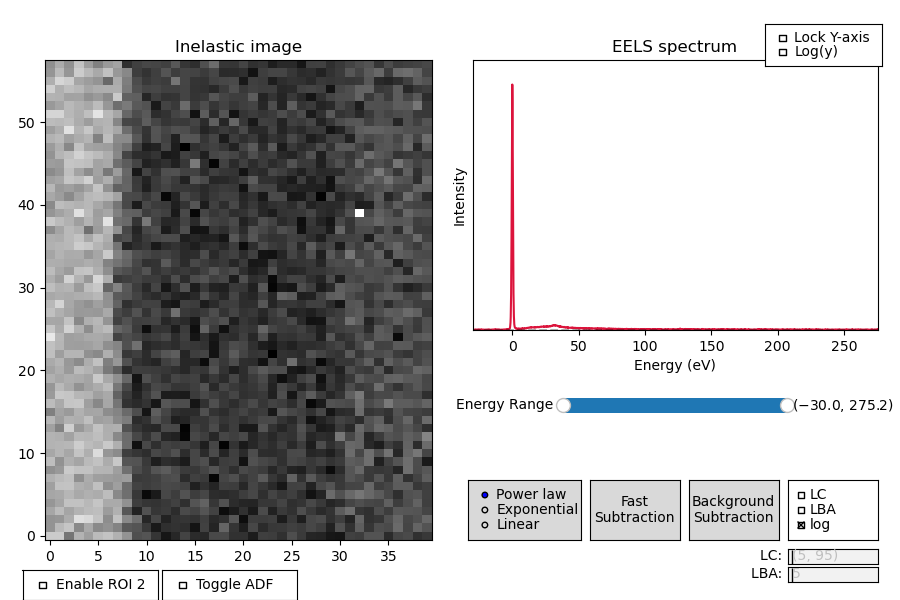

In [23]:
### Start a fit browser
# print( si_shifted )
p = EELS.SpectrumImage( si_LL_shifted, es_LL_shifted, adf=adf )
p.fitbrowser()

# High Loss

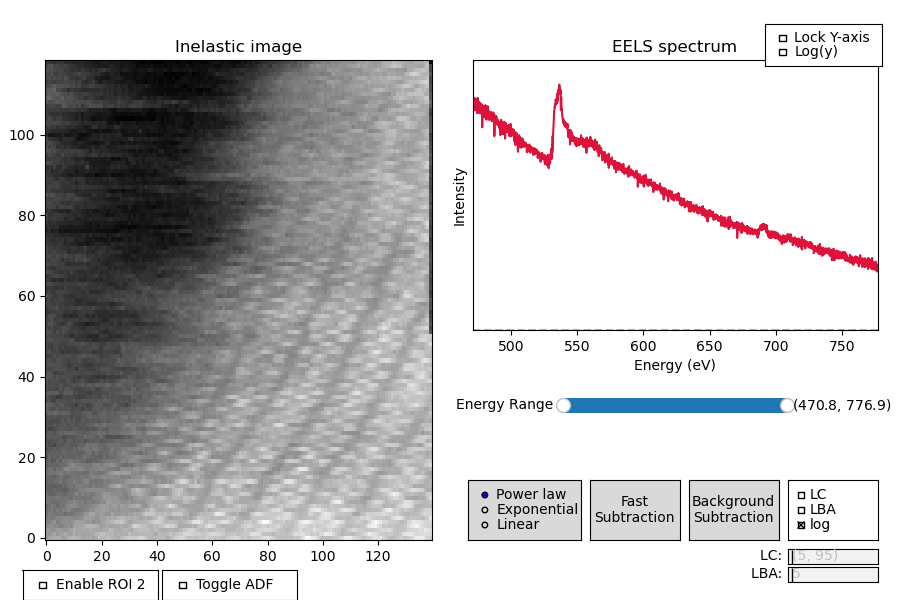

In [14]:
p = EELS.SpectrumImage( si_HL_shifted, es_HL_shifted, adf=adf )
p.fitbrowser()

In [ ]:
## Background Subtraction and Integration Window are stored in "Edge" Object
print( p.edge )

In [ ]:
## Alternatively, you can pre-define an edge
edge_O = EELS_edge( label="O-K", e_bsub=(467,521), e_int=(526, 565) )
p.fitbrowser( edge=edge_O)

In [ ]:
# Integrated inelastic image is stored in p.im_inel
fig, ax = plt.subplots(1); ax.matshow( p.im_inel )

In [ ]:
# Background subtrated SI is stored in p.si_bsub
p_bsub = EELS.SpectrumImage( p.si_bsub, p.eaxis, p.adf )
p_bsub.fitbrowser()

# Line Profile

In [ ]:
# Make Fake Lineprofile Data
lp_HL = np.mean(si_HL,0)
lp_adf = np.mean(adf,0)
p = EELS.LineProfile( lp_HL, es_HL, lp_adf )
p.fitbrowser()